# Load libraries and data

In [1]:
import copy
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

# CATBoost model
from catboost import CatBoostClassifier, Pool

# XGBoost model
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
    
# Random forest model
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
pre_test_data = pd.read_csv('Maternal Health Risk Data Set.csv')

# CatBoost without scaling and stratified sampling

In [2]:
def get_catBoost_results(X_train_strat, X_test_strat, y_train_strat, y_test_strat):
    
    # Declare input training data indices that have categorical variables
    cat_features = []
    
    # Training and test datasets prep for CatBoost
    train_CatData = Pool(data=X_train_strat, label=y_train_strat, cat_features=cat_features)
    eval_CatData = Pool(data=X_test_strat, label=y_test_strat, cat_features=cat_features)
    
    # Initialize CatBoostClassifier
    cat_model = CatBoostClassifier(iterations=1111, learning_rate=0.02778, depth=10, loss_function='MultiClass', verbose=False, random_state=11)
    
    # Fit model
    cat_model.fit(train_CatData)
    
    # Get predicted classes
    y_pred = cat_model.predict(eval_CatData)
    
    # Get predicted probabilities for each class
    preds_proba = cat_model.predict_proba(eval_CatData)
    
    # Evaluate the model
    accuracy_cb = accuracy_score(y_test_strat, y_pred)
    print(f"Test Accuracy of Random Forest: {accuracy_cb*100:.4f}%")

    # Training score
    y_train_pred = cat_model.predict(X_train_strat)
    trainScore = accuracy_score(y_train_strat, y_train_pred)
    print(f"Train Accuracy of Random Forest: {trainScore*100:.4f}%")

    df = pd.DataFrame(preds_proba, columns =['High risk prob', 'Low risk prob', 'Medium risk prob'], dtype = float)
    df['Prediction'] = y_pred.tolist()

    df['Prediction'] = df['Prediction'].astype(str)
    df['Prediction'] = df['Prediction'].str.replace("['", "")
    df['Prediction'] = df['Prediction'].str.replace("']", "")

    return y_pred, preds_proba, trainScore, df, accuracy_cb

# XGBoost without scaling and with stratified sampling

In [3]:
def get_XGBoost_results(X_train_strat, X_test_strat, y_train_strat, y_test_strat):

    le = LabelEncoder()
    y_trainXGb = le.fit_transform(y_train_strat)
    
    # Train the Random Forest classifier
    clf_xgboost = XGBClassifier(max_depth = 10, random_state=11)
    clf_xgboost.fit(X_train_strat, y_trainXGb)
    
    # Predict on test set
    y_pred = clf_xgboost.predict(X_test_strat)
    y_pred = le.inverse_transform(y_pred)

    # Get predicted probabilities for each class
    preds_proba = clf_xgboost.predict_proba(X_test_strat)
    
    # Evaluate the model
    accuracy_xg = accuracy_score(y_test_strat, y_pred)
    print(f"Test Accuracy of Random Forest: {accuracy_xg*100:.4f}%")

    # Training score
    y_train_pred = clf_xgboost.predict(X_train_strat)
    y_train_pred = le.inverse_transform(y_train_pred)
    trainScore = accuracy_score(y_train_strat, y_train_pred)
    print(f"Train Accuracy of Random Forest: {trainScore*100:.4f}%")

    df = pd.DataFrame(preds_proba, columns =['High risk prob', 'Low risk prob', 'Medium risk prob'], dtype = float)
    df['Prediction'] = y_pred

    return y_pred, preds_proba, trainScore, df, accuracy_xg

# Random forest without scaling and with stratified sampling

In [4]:
def get_RandForest_results(X_train_strat, X_test_strat, y_train_strat, y_test_strat):
    
    # Train the Random Forest classifier
    clf_rf = RandomForestClassifier(n_estimators=205, max_leaf_nodes=8, max_features='sqrt', max_depth=14, random_state=11)
    clf_rf.fit(X_train_strat, y_train_strat)
    
    # Predict on test set
    y_pred = clf_rf.predict(X_test_strat)

    # Get predicted probabilities for each class
    preds_proba = clf_rf.predict_proba(X_test_strat)

    # Evaluate the model
    accuracy_rf = accuracy_score(y_test_strat, y_pred)
    print(f"Test Accuracy of Random Forest: {accuracy_rf*100:.4f}%")

    # Training score
    y_train_pred = clf_rf.predict(X_train_strat)
    trainScore = accuracy_score(y_train_strat, y_train_pred)
    print(f"Train Accuracy of Random Forest: {trainScore*100:.4f}%")

    df = pd.DataFrame(preds_proba, columns =['High risk prob', 'Low risk prob', 'Medium risk prob'], dtype = float)
    df['Prediction'] = y_pred
    
    return y_pred, preds_proba, trainScore, df, accuracy_rf

# Weighted average ensemble

In [5]:
def get_WeightedEnsemble_results(cat_df, xgb_df, raf_df, cat_scr, xgb_scr, raf_scr, y_test_str):

    # Compute the weights for each method using training scores
    tot_scr = cat_scr + xgb_scr + raf_scr
    cat_wght = cat_scr/tot_scr
    xgb_wght = xgb_scr/tot_scr
    raf_wght = raf_scr/tot_scr

    # Create an empty dataframe to share the final results
    df = pd.DataFrame(columns =['high risk prob', 'low risk prob', 'mid risk prob'], dtype = float)

    # Compute the final values and store the results in the dataframe

    for i in range(len(cat_df)):
        highcatVal = cat_wght*cat_df['High risk prob'].iloc[i]
        highxgbVal = xgb_wght*xgb_df['High risk prob'].iloc[i]
        highrafVal = raf_wght*raf_df['High risk prob'].iloc[i]

        lowcatVal = cat_wght*cat_df['Low risk prob'].iloc[i]
        lowxgbVal = xgb_wght*xgb_df['Low risk prob'].iloc[i]
        lowrafVal = raf_wght*raf_df['Low risk prob'].iloc[i]

        medcatVal = cat_wght*cat_df['Medium risk prob'].iloc[i]
        medxgbVal = xgb_wght*xgb_df['Medium risk prob'].iloc[i]
        medrafVal = raf_wght*raf_df['Medium risk prob'].iloc[i]

        highVal = highcatVal + highxgbVal + highrafVal
        lowVal = lowcatVal + lowxgbVal + lowrafVal
        medVal = medcatVal + medxgbVal + medrafVal
        
        df.loc[len(df.index)] = [highVal, lowVal, medVal]

        del(highVal, lowVal, medVal)

    df['Prediction'] = df.idxmax(axis=1)
    df['Prediction'] = df['Prediction'].astype(str)
    df['Prediction'] = df['Prediction'].str.replace(" prob", "")

    actual_list = list(y_test_str)
    df['Actual'] = actual_list

    df.to_csv('final_prediction_values.csv', index=False)
    
    return df

# Rough Work

In [6]:
# Import Required Modules.
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

# Empty list for storing accuracies
ensemble_accuracy = []
cb_accuracy = []
xg_accuracy = []
rf_accuracy = []

for train_index, test_index in skf.split(pre_test_data, pre_test_data['Risk_Level']):
    strat_train_set = pre_test_data.loc[train_index]
    strat_test_set = pre_test_data.loc[test_index]

    X_train_strat = strat_train_set[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'Body Temp', 'Heart Rate']]
    y_train_strat = strat_train_set['Risk_Level']
    
    X_test_strat = strat_test_set[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'Body Temp', 'Heart Rate']]
    y_test_strat = strat_test_set['Risk_Level']

    predC, probC, scrC, dfC, acrC = get_catBoost_results(X_train_strat, X_test_strat, y_train_strat, y_test_strat)
    predX, probX, scrX, dfX, acrX = get_XGBoost_results(X_train_strat, X_test_strat, y_train_strat, y_test_strat)
    predR, probR, scrR, dfR, acrR = get_RandForest_results(X_train_strat, X_test_strat, y_train_strat, y_test_strat)

    finalPred_df = get_WeightedEnsemble_results(dfC, dfX, dfR, scrC, scrX, scrR, y_test_strat)

    # Evaluate the model
    accuracy_rf = accuracy_score(y_test_strat, finalPred_df['Prediction'])
    print(f"Accuracy of Random Forest: {accuracy_rf*100:.4f}%")

    ensemble_accuracy.append(accuracy_rf*100)
    cb_accuracy.append(acrC*100)
    xg_accuracy.append(acrX*100)
    rf_accuracy.append(acrR*100)

Test Accuracy of Random Forest: 84.3137%
Train Accuracy of Random Forest: 92.9825%
Test Accuracy of Random Forest: 83.3333%
Train Accuracy of Random Forest: 92.9825%
Test Accuracy of Random Forest: 68.6275%
Train Accuracy of Random Forest: 71.6009%
Accuracy of Random Forest: 84.3137%
Test Accuracy of Random Forest: 90.1961%
Train Accuracy of Random Forest: 92.3246%
Test Accuracy of Random Forest: 91.1765%
Train Accuracy of Random Forest: 92.3246%
Test Accuracy of Random Forest: 75.4902%
Train Accuracy of Random Forest: 70.8333%
Accuracy of Random Forest: 90.1961%
Test Accuracy of Random Forest: 86.2745%
Train Accuracy of Random Forest: 92.5439%
Test Accuracy of Random Forest: 89.2157%
Train Accuracy of Random Forest: 92.5439%
Test Accuracy of Random Forest: 72.5490%
Train Accuracy of Random Forest: 69.9561%
Accuracy of Random Forest: 88.2353%
Test Accuracy of Random Forest: 84.3137%
Train Accuracy of Random Forest: 92.4342%
Test Accuracy of Random Forest: 84.3137%
Train Accuracy of Ran

In [7]:
ensemble_accuracy

[84.31372549019608,
 90.19607843137256,
 88.23529411764706,
 84.31372549019608,
 85.14851485148515,
 91.0891089108911,
 89.10891089108911,
 90.0990099009901,
 84.15841584158416,
 90.0990099009901]

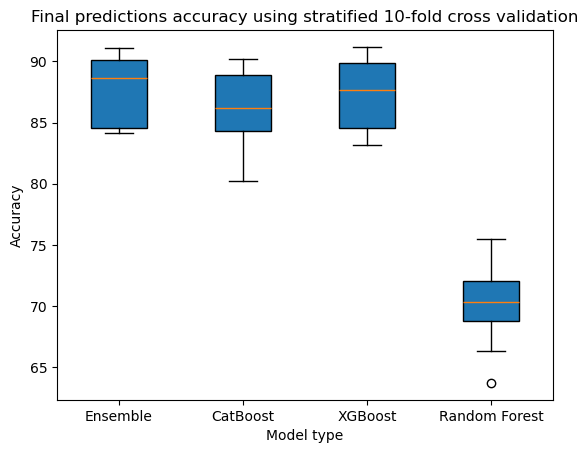

In [9]:
import matplotlib.pyplot as plt

data = [ensemble_accuracy, cb_accuracy, xg_accuracy, rf_accuracy]
labels = ['Ensemble', 'CatBoost', 'XGBoost', 'Random Forest']

plt.boxplot(data, labels=labels, patch_artist=True)
plt.xlabel("Model type")
plt.ylabel("Accuracy")
plt.title("Final predictions accuracy using stratified 10-fold cross validation")
plt.savefig("final_prediction.png", dpi=600, transparent=True, bbox_inches='tight')
plt.show()